In [1]:
import warnings
warnings.filterwarnings('ignore') 

from adversarial_models import * 
from utils import *
from get_data import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd

import lime
import lime.lime_tabular
import shap
from copy import deepcopy

2024-06-02 15:26:48.142060: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
params = Params("model_configurations/experiment_params.json")
np.random.seed(params.seed)
X, y, cols = get_and_preprocess_cicids(params)

# Add a random column -- this is what we'll have LIME/SHAP explain.
X['unrelated_column'] = np.random.choice([0,1],size=X.shape[0])
features = [c for c in X]

categorical_feature_name = [' Init_Win_bytes_backward',
                            ' Destination Port',' Fwd Packet Length Std',
                            ' Flow IAT Max','Total Length of Fwd Packets', 
                            'unrelated_column']

categorical_feature_indcs = [features.index(c) for c in categorical_feature_name]

race_indc = features.index(' Flow Duration')
unrelated_indcs = features.index('unrelated_column')
X = X.values

---------------------------------------------------------------------------------
Loading Databases
---------------------------------------------------------------------------------

---------------------------------------------------------------------------------
Reducing Normal rows
---------------------------------------------------------------------------------

['Normal', 'Attack']


In [3]:
# race_indc

In [4]:
from collections import Counter
print(Counter(y))

Counter({0: 216231, 1: 31844})


In [5]:
class racist_model_f:
    # Decision rule: classify negatively if race is black
    def predict(self,X):
        return np.array([params.negative_outcome if x[race_indc] > 0 else params.positive_outcome for x in X])

    def predict_proba(self, X): 
        return one_hot_encode(self.predict(X))

    def score(self, X,y):
        return np.sum(self.predict(X)==y) / len(X)
    
class innocuous_model_psi:
    # Decision rule: classify according to randomly drawn column 'unrelated column'
    def predict(self,X):
        return np.array([params.negative_outcome if x[unrelated_indcs] > 0 else params.positive_outcome for x in X])

    def predict_proba(self, X): 
        return one_hot_encode(self.predict(X))

    def score(self, X,y):
        return np.sum(self.predict(X)==y) / len(X)

In [6]:
# Split the data and normalize
xtrain,xtest,ytrain,ytest = train_test_split(X,y)
xtest_not_normalized = deepcopy(xtest)
ss = StandardScaler().fit(xtrain)
xtrain = ss.transform(xtrain)
xtest = ss.transform(xtest)



In [7]:

import tensorflow as tf

# Now you can use Keras modules directly from tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten

# import keras
# from keras.models import Sequential
# from keras.layers import Dense, Flatten
import innvestigate
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.callbacks import LearningRateScheduler


In [8]:

# Train the adversarial model
adv_shap = Adversarial_Kernel_SHAP_Model(racist_model_f(), innocuous_model_psi()).\
            train(xtrain, ytrain, feature_names=features, estimator = True)

Train on 1504448 samples


2024-06-02 15:36:24.879654: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-06-02 15:36:24.891733: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:67:00.0 name: NVIDIA RTX A6000 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 84 deviceMemorySize: 47.54GiB deviceMemoryBandwidth: 715.34GiB/s
2024-06-02 15:36:24.891908: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:68:00.0 name: NVIDIA RTX A6000 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 84 deviceMemorySize: 47.53GiB deviceMemoryBandwidth: 715.34GiB/s
2024-06-02 15:36:24.891945: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-06-02 15:36:24.932462: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-06

Epoch 1/20
1504448/1504448 [==============================] - 1s 1us/sample - loss: 0.6472 - accuracy: 0.9587
Epoch 2/20
1504448/1504448 [==============================] - 1s 1us/sample - loss: 0.5034 - accuracy: 0.9893
Epoch 3/20
1504448/1504448 [==============================] - 1s 1us/sample - loss: 0.3725 - accuracy: 0.9893
Epoch 4/20
1504448/1504448 [==============================] - 1s 1us/sample - loss: 0.2595 - accuracy: 0.9893
Epoch 5/20
1504448/1504448 [==============================] - 1s 1us/sample - loss: 0.1744 - accuracy: 0.9893
Epoch 6/20
1504448/1504448 [==============================] - 1s 1us/sample - loss: 0.1151 - accuracy: 0.9893
Epoch 7/20
1504448/1504448 [==============================] - 1s 1us/sample - loss: 0.0811 - accuracy: 0.9893
Epoch 8/20
1504448/1504448 [==============================] - 1s 1us/sample - loss: 0.0658 - accuracy: 0.9899
Epoch 9/20
1504448/1504448 [==============================] - 1s 1us/sample - loss: 0.0673 - accuracy: 0.9897
Epoch 10/2

100%|██████████| 1/1 [00:00<00:00, 30.13it/s]


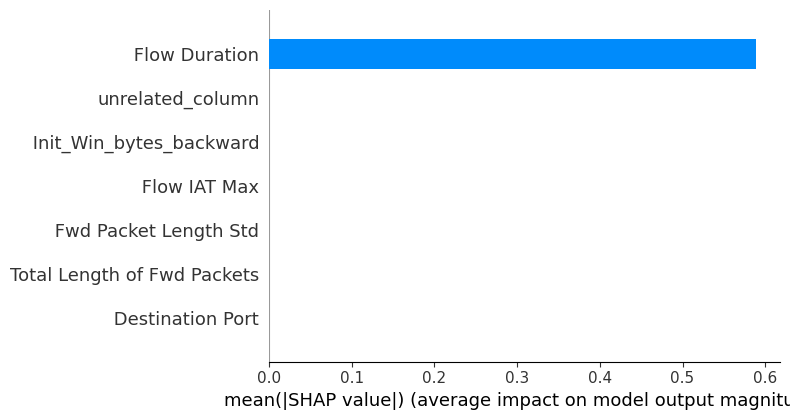

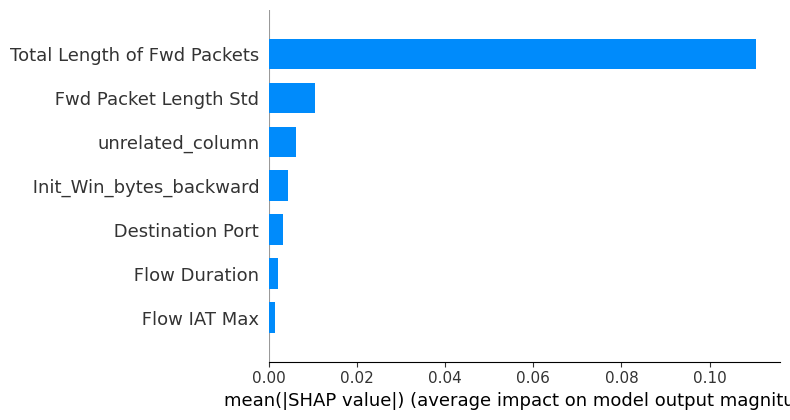

Fidelity: 1.0


In [9]:
# Set the background distribution for the shap explainer using kmeans
background_distribution = shap.kmeans(xtrain,10)

# Let's use the shap kernel explainer and grab a point to explain
to_examine = np.random.choice(xtest.shape[0])

# # Explain the biased model
biased_kernel_explainer = shap.KernelExplainer(racist_model_f().predict, background_distribution)
biased_shap_values = biased_kernel_explainer.shap_values(xtest[to_examine:to_examine+1])

# Convert DenseData to numpy array
background_distribution_array = background_distribution.data

# Explain the adversarial model
adv_kerenel_explainer = shap.DeepExplainer(adv_shap.perturbation_identifier, background_distribution_array)
adv_shap_values = adv_kerenel_explainer.shap_values(xtest[to_examine:to_examine+1])

# Plot it using SHAP's plotting features.
shap.summary_plot(biased_shap_values, feature_names=features, plot_type="bar")
shap.summary_plot(adv_shap_values[0], feature_names=features, plot_type="bar")

print ("Fidelity: {0:3.2}".format(adv_shap.fidelity(xtest[to_examine:to_examine+1])))



In [10]:
xtest.shape[0]

62019

In [11]:
# 4 buckets, 3 graphs
dict_biased_1 = {
    'Biased': 0,
    'Unrelated_1':0,
    'Unrelated_2':0,
    'Others':0
}
dict_biased_2 = {
    'Biased': 0,
    'Unrelated_1':0,
    'Unrelated_2':0,
    'Others':0
}
dict_biased_3 = {
    'Biased': 0,
    'Unrelated_1':0,
    'Unrelated_2':0,
    'Others':0
}
attack_1 = {
    'Biased': 0,
    'Unrelated_1':0,
    'Unrelated_2':0,
    'Others':0
}

attack_2 = {
    'Biased': 0,
    'Unrelated_1':0,
    'Unrelated_2':0,
    'Others':0
}

attack_3 = {
    'Biased': 0,
    'Unrelated_1':0,
    'Unrelated_2':0,
    'Others':0
}


In [12]:
# features analyzed
biased_feature = ' Flow Duration'
Unrelated_1_feature = 'unrelated_column'
# Unrelated_2_feature = 'unrelated_column'
samples = 100

In [13]:
for i in range(0,samples):   
 # Set the background distribution for the shap explainer using kmeans
    background_distribution = shap.kmeans(xtrain,10)

    # Let's use the shap kernel explainer and grab a point to explain
    to_examine = i

    # to_examine = np.random.choice(xtest.shape[0])

    # Explain the biased model
    biased_kernel_explainer = shap.KernelExplainer(racist_model_f().predict, background_distribution)
    biased_shap_values = biased_kernel_explainer.shap_values(xtest[to_examine:to_examine+1])


    # # Explain the adversarial model
    # adv_kerenel_explainer = shap.KernelExplainer(adv_shap.predict, background_distribution)
    # adv_shap_values = adv_kerenel_explainer.shap_values(xtest[to_examine:to_examine+1])


    # Convert DenseData to numpy array
    background_distribution_array = background_distribution.data

    # Explain the adversarial model
    adv_kerenel_explainer = shap.DeepExplainer(adv_shap.perturbation_identifier, background_distribution_array)
    adv_shap_values = adv_kerenel_explainer.shap_values(xtest[to_examine:to_examine+1])

    # Plot it using SHAP's plotting features.
    # shap.summary_plot(biased_shap_values, feature_names=features, plot_type="bar")
    # shap.summary_plot(adv_shap_values, feature_names=features, plot_type="bar")

    # print(adv_shap_values)
    # print(features)

    biased_df = pd.DataFrame({
            'shap_values': biased_shap_values[0],
            'shap_values_abs': abs(biased_shap_values[0]),
            'features': features    
        })
    
    # index_prediction = np.argmax(adv_shap.perturbation_identifier.predict(xtest[0:1]))

    attack1_df = pd.DataFrame({
            'shap_values': adv_shap_values[0][0],
            'shap_values_abs':abs(np.array(adv_shap_values[0][0])),
            'features': features    
        })
    # info = [adv_shap_values,features]

    attack1_df.sort_values(by=['shap_values_abs'], ascending=False,inplace=True)
    biased_df.sort_values(by=['shap_values_abs'], ascending=False,inplace=True)

    attack1_df = attack1_df.reset_index(drop=True)
    biased_df = biased_df.reset_index(drop=True)

    # print('Attack')
    # print('------------------------------')
    # print (attack1_df)
    # print('Biased')
    # print('------------------------------')
    # print(biased_df)


    #biased columns

    #For 1st position
    if biased_df['features'][0] == biased_feature: dict_biased_1['Biased'] = dict_biased_1['Biased'] + 1
    elif biased_df['features'][0] == Unrelated_1_feature: dict_biased_1['Unrelated_1'] = dict_biased_1['Unrelated_1'] + 1
    # elif biased_df['features'][0] == Unrelated_2_feature: dict_biased_1['Unrelated_2'] = dict_biased_1['Unrelated_2'] + 1
    else: dict_biased_1['Others'] = dict_biased_1['Others'] + 1

    #For 2st position
    if biased_df['features'][1] == biased_feature: dict_biased_2['Biased'] = dict_biased_2['Biased'] + 1
    elif biased_df['features'][1] == Unrelated_1_feature: dict_biased_2['Unrelated_1'] = dict_biased_2['Unrelated_1'] + 1
    # elif biased_df['features'][1] == Unrelated_2_feature: dict_biased_2['Unrelated_2'] = dict_biased_2['Unrelated_2'] + 1
    else: dict_biased_2['Others'] = dict_biased_2['Others'] + 1

    #For 3st position
    if biased_df['features'][2] == biased_feature: dict_biased_3['Biased'] = dict_biased_3['Biased'] + 1
    elif biased_df['features'][2] == Unrelated_1_feature: dict_biased_3['Unrelated_1'] = dict_biased_3['Unrelated_1'] + 1
    # elif biased_df['features'][2] == Unrelated_2_feature: dict_biased_3['Unrelated_2'] = dict_biased_3['Unrelated_2'] + 1
    else: dict_biased_3['Others'] = dict_biased_3['Others'] + 1


    #Attack 1 columns

    #For 1st position
    if attack1_df['features'][0] == biased_feature: attack_1['Biased'] = attack_1['Biased'] + 1
    elif attack1_df['features'][0] == Unrelated_1_feature: attack_1['Unrelated_1'] = attack_1['Unrelated_1'] + 1
    # elif attack1_df['features'][0] == Unrelated_2_feature: attack_1['Unrelated_2'] = attack_1['Unrelated_2'] + 1
    else: attack_1['Others'] = attack_1['Others'] + 1

    #For 2st position
    if attack1_df['features'][1] == biased_feature: attack_2['Biased'] = attack_2['Biased'] + 1
    elif attack1_df['features'][1] == Unrelated_1_feature: attack_2['Unrelated_1'] = attack_2['Unrelated_1'] + 1
    # elif attack1_df['features'][1] == Unrelated_2_feature: attack_2['Unrelated_2'] = attack_2['Unrelated_2'] + 1
    else: attack_2['Others'] = attack_2['Others'] + 1

    #For 3st position
    if attack1_df['features'][2] == biased_feature: attack_3['Biased'] = attack_3['Biased'] + 1
    elif attack1_df['features'][2] == Unrelated_1_feature: attack_3['Unrelated_1'] = attack_3['Unrelated_1'] + 1
    # elif attack1_df['features'][2] == Unrelated_2_feature: attack_3['Unrelated_2'] = attack_3['Unrelated_2'] + 1
    else: attack_3['Others'] = attack_3['Others'] + 1


# print ("Fidelity: {0:3.2}".format(adv_shap.fidelity(xtest[to_examine:to_examine+1])))

100%|██████████| 1/1 [00:00<00:00, 122.89it/s]


In [14]:
#Normalized
keys = ['Biased','Unrelated_1','Unrelated_2','Others' ]
for x in keys:

    dict_biased_1[x] = dict_biased_1[x]/samples
    dict_biased_2[x] = dict_biased_2[x]/samples
    dict_biased_3[x] = dict_biased_3[x]/samples

    attack_1[x] = attack_1[x]/samples
    attack_2[x] = attack_2[x]/samples
    attack_3[x] = attack_3[x]/samples

In [15]:
print(dict_biased_1 )
print(dict_biased_2 )
print(dict_biased_3 )
print('--------------')
print(attack_1 )
print(attack_2 )
print(attack_3 )

{'Biased': 1.0, 'Unrelated_1': 0.0, 'Unrelated_2': 0.0, 'Others': 0.0}
{'Biased': 0.0, 'Unrelated_1': 0.0, 'Unrelated_2': 0.0, 'Others': 1.0}
{'Biased': 0.0, 'Unrelated_1': 0.0, 'Unrelated_2': 0.0, 'Others': 1.0}
--------------
{'Biased': 0.0, 'Unrelated_1': 0.01, 'Unrelated_2': 0.0, 'Others': 0.99}
{'Biased': 0.03, 'Unrelated_1': 0.16, 'Unrelated_2': 0.0, 'Others': 0.81}
{'Biased': 0.3, 'Unrelated_1': 0.46, 'Unrelated_2': 0.0, 'Others': 0.24}


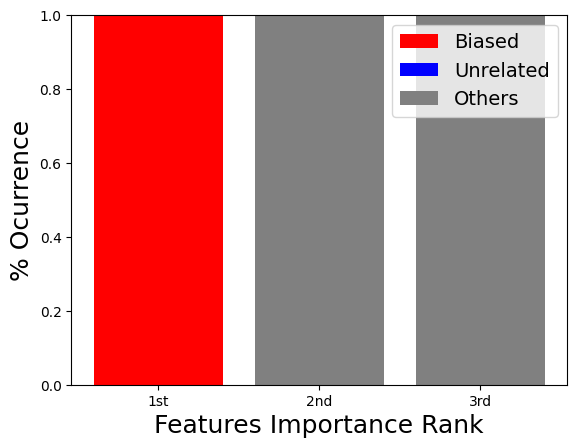

In [16]:
# importing package
import matplotlib.pyplot as plt
import numpy as np
total = samples 
# create data
x = ['1st', '2nd', '3rd']
y1 = np.array([dict_biased_1['Biased'], dict_biased_2['Biased'], dict_biased_3['Biased']])
y2 = np.array([dict_biased_1['Unrelated_1'], dict_biased_2['Unrelated_1'], dict_biased_3['Unrelated_1']])
y3 = np.array([dict_biased_1['Others'], dict_biased_2['Others'], dict_biased_3['Others']])
y4 = np.array([dict_biased_1['Unrelated_2'], dict_biased_2['Unrelated_2'],dict_biased_3['Unrelated_2']])


# plot bars in stack manner
plt.bar(x, y1, color='r')
plt.bar(x, y2, bottom=y1, color='b')
plt.bar(x, y3, bottom=y1+y2, color='grey')
# plt.bar(x, y4, bottom=y1+y2+y3, color='g')
plt.xlabel("Features Importance Rank", fontsize = 18)
plt.ylabel("% Ocurrence", fontsize = 18)
# plt.legend(["Biased", "Unrelated", "Unrelated_2", "Others"])
plt.legend(["Biased", "Unrelated", "Others"], fontsize = 14)

plt.show()


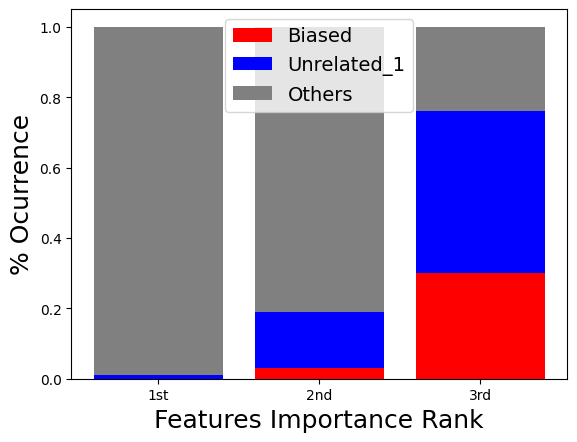

In [17]:
# importing package
import matplotlib.pyplot as plt
import numpy as np
total = samples 
# create data
x = ['1st', '2nd', '3rd']
y1 = np.array([attack_1['Biased'], attack_2['Biased'], attack_3['Biased']])
y2 = np.array([attack_1['Unrelated_1'], attack_2['Unrelated_1'], attack_3['Unrelated_1']])
y3 = np.array([attack_1['Others'], attack_2['Others'],attack_3['Others']])
# y4 = np.array([attack_1['Unrelated_2'], attack_2['Unrelated_2'], attack_3['Unrelated_2']])

# plot bars in stack manner
plt.bar(x, y1, color='r')
plt.bar(x, y2, bottom=y1, color='b')
plt.bar(x, y3, bottom=y1+y2, color='grey')
# plt.bar(x, y4, bottom=y1+y2+y3, color='g')
plt.xlabel("Features Importance Rank", fontsize = 18)
plt.ylabel("% Ocurrence", fontsize = 18)
# plt.legend(["Biased", "Unrelated_1", "Unrelated_2", "Others"])
plt.legend(["Biased", "Unrelated_1", "Others"], fontsize = 14)

plt.show()
